In [ ]:
from pathlib import Path
from pprint import pprint
from typing import Any, Dict

import numpy as np
import pandas as pd
from scipy.io import loadmat

from main import Weather
from main import Soil

Array = np.ndarray

DATA_PATH = Path("data")

In [ ]:
# -----------------------------
# Utility helpers
# -----------------------------
def load_matlab_file_as_dict(filename: str, verbose=False) -> Dict[str, Any]:
    loaded_dict: Dict[str, Any] = loadmat(DATA_PATH / "Soil" / filename)
    if verbose:
        pprint(loaded_dict.keys())
    return loaded_dict


def load_wheather(path):
    df = pd.read_csv(path, sep=";")
    df["FECHA"] = pd.to_datetime(df["FECHA"], format="%Y%m%d")
    df.rename(
        columns={
            "TMED(C)": "temp",
            "RAD(MJ/M2)": "par",
            "LLUVIA(mm)": "precip",
            "EVAP_TRANS(mm)": "et0",
        },
        inplace=True,
    )
    return df

In [ ]:
# -----------------------------
# Set parameters from data files
# -----------------------------

mask_maize: Array = load_matlab_file_as_dict("mat_maiz_2021_lowres.mat")[
    "clase_maiz_2021_lowres"
]
lat: Array = load_matlab_file_as_dict("mat_maiz_2021_lat_lowres.mat")["lat_lowres"]
lon: Array = load_matlab_file_as_dict("mat_maiz_2021_lon_lowres.mat")["lon_lowres"]
dds0: Array = load_matlab_file_as_dict("mat_dds_maiz_est_lowres.mat")["dds_est"]
water0: Array = (
    load_matlab_file_as_dict("mat_aguadisp_saocom_maiz_2021-2022_2.mat")["a_disp_campo"]
    / 100.0
)  # Si water0 es entre (0,1) hay que dividir. Pregungar a jero. Porcentaje de agua util.

df_weather: pd.DataFrame = load_wheather(DATA_PATH / "Weather" / "weather.csv")

In [ ]:
# -----------------------------
# Initialize Soil model
# -----------------------------
weather = Weather(
    temp=df_weather["temp"],
    par=df_weather["par"],
    precip=df_weather["precip"],
    et0=df_weather["et0"],
)

target_crop = "maize"
soil = Soil(
    mask_maize=mask_maize,
    mask_soy=np.zeros_like(mask_maize),
    lat=lat,
    lon=lon,
    water0=water0,
    dds0=dds0,
)

In [ ]:
# -----------------------------
# Run simulation
# -----------------------------
results = soil.evolve(target_crop, weather)

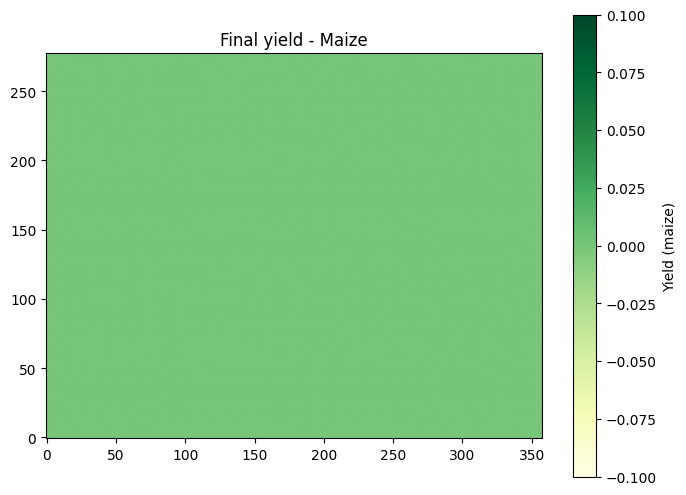

In [ ]:
import matplotlib.pyplot as plt

# Último valor en el tiempo (t = T-1)
final_yield_maize = results.yield_[:, :, -1]


# Gráfico de maíz
plt.figure(figsize=(8, 6))
plt.imshow(final_yield_maize, cmap="YlGn", origin="lower")
plt.colorbar(label="Yield (maize)")
plt.title("Final yield - Maize")
plt.show()

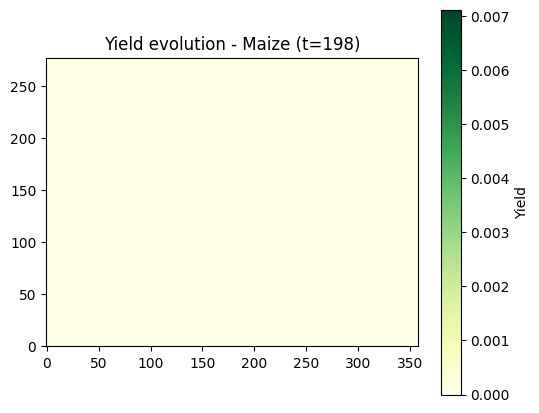

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

rc("animation", html="jshtml")  # clave para que se renderice en la celda

data = results.yield_  # (nx, ny, T)
T = data.shape[-1]

vmin = np.nanmin(data)
vmax = np.nanmax(data)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(data[:, :, 0], origin="lower", vmin=vmin, vmax=vmax, cmap="YlGn")
cbar = plt.colorbar(im, ax=ax, label="Yield")
ax.set_title("Yield evolution - Maize (t=0)")


def update(t):
    im.set_array(data[:, :, t])
    ax.set_title(f"Yield evolution - Maize (t={t})")
    return [im]


ani = animation.FuncAnimation(fig, update, frames=T, interval=200, blit=True)

HTML(ani.to_jshtml())